In [ ]:
import warnings

warnings.filterwarnings("ignore")

# Getting started

Welcome to the getting started guide of *PedPy*, we want to guide you through the first steps to set up an analysis of a pedestrian experiment.
In this guide, you will learn how to load the movement data, set up measurement areas, and finally compute the flow and the densities. 

First things first, to use *PedPy* install it via:

```bash
pip install pedpy
```

Now, you are ready to set up your first analysis with *PedPy*.

If you want to follow this Jupyter Notebook on your own machine, you can download it 
{download}`here <getting_started.ipynb>`.

If you use *PedPy* in your work, please cite it using the following information from zenodo:
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7386931.svg)](https://doi.org/10.5281/zenodo.7386931)



## Let's analyze an experiment

This is a bottleneck experiment conducted at the University of Wuppertal in 2018.
You can see the basic setup of the experiment in the picture below:

```{eval-rst}
.. figure:: demo-data/bottleneck/040_c_56_h-.png
    :width: 400px
    :align: center
```

The data for this experiment is available {download}`here <demo-data/bottleneck/040_c_56_h-.txt>`, which belongs to this [experimental series](https://doi.org/10.34735/ped.2018.1) and is part of the publication ["Crowds in front of bottlenecks at entrances from the perspective of physics and social psychology"](https://doi.org/10.1098/rsif.2019.0871).
For our analysis, we are interested in the flow at the bottleneck and density a short distance in front of the bottleneck.


## Importing pedestrian movement data

The pedestrian movement data in *PedPy* is called trajectory data.

*PedPy* works with {class}`trajectory data <trajectory_data.TrajectoryData>` which can be created from an import function for specific data files alternatively from a {class}`~pandas.DataFrame` with the following columns:
 
- "id": a unique numeric identifier for each person
- "frame": index of video frame where the positions were extracted
- "x", "y": position of the person (in m) 

*PedPy* provides an import function to load trajectory data provided [here](https://ped.fz-juelich.de/da/doku.php).
Since the data we want to analyze is from there, we can directly load the trajectory data with *PedPy*:  

In [1]:
from pedpy import load_trajectory
import pathlib

traj = load_trajectory(
    trajectory_file=pathlib.Path("demo-data/bottleneck/040_c_56_h-.txt")
)
traj

TrajectoryData:
        frame rate: 25.0
        frames: [(0, 1656)]
        number pedestrians: 75
        bounding box: (-2.6042, -1.8723, 2.2641, 5.98)
        data: 
           id  frame       x       y                  point
0   1      0  2.1569  2.6590   POINT (2.1569 2.659)
1   1      1  2.1498  2.6653  POINT (2.1498 2.6653)
2   1      2  2.1532  2.6705  POINT (2.1532 2.6705)
3   1      3  2.1557  2.6496  POINT (2.1557 2.6496)
4   1      4  2.1583  2.6551  POINT (2.1583 2.6551)
5   1      5  2.1643  2.6508  POINT (2.1643 2.6508)
6   1      6  2.1723  2.6477  POINT (2.1723 2.6477)
7   1      7  2.1845  2.6485  POINT (2.1845 2.6485)
8   1      8  2.1988  2.6491  POINT (2.1988 2.6491)
9   1      9  2.2138  2.6540   POINT (2.2138 2.654)
        

The loaded trajectories look like:


In [ ]:
from pedpy import plot_trajectories
import matplotlib.pyplot as plt

plot_trajectories(
    traj=traj,
    traj_alpha=0.5,
    traj_width=1,
).set_aspect("equal")
plt.show()

## Let's analyze the flow at the bottleneck

For this analysis, we need to define a line where we want to measure the flow (see {class}`~geometry.MeasurementLine`).
We place the line at the bottleneck as below:


In [2]:
from pedpy import MeasurementLine

measurement_line = MeasurementLine([(0.25, 0), (-0.25, 0)])

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

ax = plot_measurement_setup(
    traj=traj,
    traj_alpha=0.5,
    traj_width=1,
    measurement_lines=[measurement_line],
    ml_width=2,
).set_aspect("equal")
plt.show()

The flow calculation is done with {func}`~flow_calculator.compute_n_t`, with our trajectory data, the measurement line ,and the frame rate the data was recorded.

In [3]:
from pedpy import compute_n_t

nt, _ = compute_n_t(
    traj_data=traj,
    measurement_line=measurement_line,
)

NameError: name 'plt' is not defined

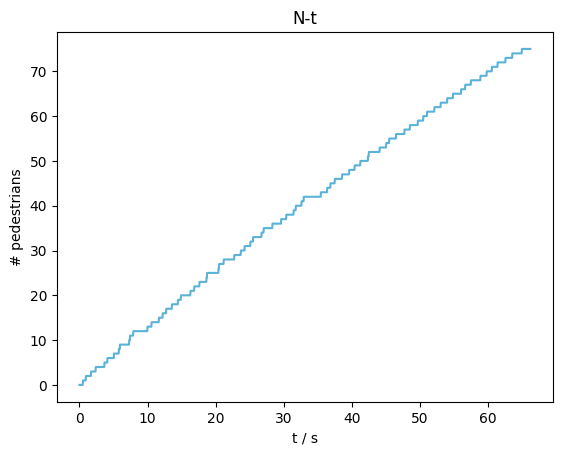

In [4]:
from pedpy import plot_nt

plot_nt(nt=nt)
plt.show()

## Let's compute the density in front of the bottleneck

Now we are computing the density in an area in front of the bottleneck.
The density is usually not measured directly at the bottleneck, but a short distance in front as here the highest densities occur.

For this we need to define a {class}`measurement area<geometry.MeasurementArea>`, which has to be a convex polygon.
Such a measurement area can be created with: 

In [ ]:
from pedpy import MeasurementArea

measurement_area = MeasurementArea(
    [(-0.4, 0.5), (0.4, 0.5), (0.4, 1.3), (-0.4, 1.3)]
)

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

plot_measurement_setup(
    traj=traj,
    traj_alpha=0.5,
    traj_width=1,
    measurement_areas=[measurement_area],
    ma_line_width=2,
).set_aspect("equal")
plt.show()

The density over time is now computed by {func}`~density_calculator.compute_classic_density`, which takes the trajectory data and measurement area as inputs:

In [ ]:
from pedpy import compute_classic_density

classic_density = compute_classic_density(
    traj_data=traj, measurement_area=measurement_area
)

In [ ]:
from pedpy import plot_density
import matplotlib.pyplot as plt

plot_density(density=classic_density, title="Classic density over time")
plt.show()

## Now use the Voronoi method for computing the density

For this we now need information about the area where pedestrians can move, this is called a {class}`walkable area<geometry.WalkableArea>` in *PedPy* and is essentially a 2D polygon.
We extract the walkable area from this diagram:

```{eval-rst}
.. figure:: demo-data/bottleneck/experimental_setup.png
    :width: 400px
    :align: center
```

The resulting polygon is described in the code below:


In [ ]:
from pedpy import WalkableArea

walkable_area = WalkableArea(
    # complete area
    [
        (3.5, -2),
        (3.5, 8),
        (-3.5, 8),
        (-3.5, -2),
    ],
    obstacles=[
        # left barrier
        [
            (-0.7, -1.1),
            (-0.25, -1.1),
            (-0.25, -0.15),
            (-0.4, 0.0),
            (-2.8, 0.0),
            (-2.8, 6.7),
            (-3.05, 6.7),
            (-3.05, -0.3),
            (-0.7, -0.3),
            (-0.7, -1.0),
        ],
        # right barrier
        [
            (0.25, -1.1),
            (0.7, -1.1),
            (0.7, -0.3),
            (3.05, -0.3),
            (3.05, 6.7),
            (2.8, 6.7),
            (2.8, 0.0),
            (0.4, 0.0),
            (0.25, -0.15),
            (0.25, -1.1),
        ],
    ],
)

The resulting walkable area will look like this, together with the trajectories and the measurement area:

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

plot_measurement_setup(
    walkable_area=walkable_area,
    traj=traj,
    traj_alpha=0.5,
    traj_width=1,
    measurement_areas=[measurement_area],
    ma_line_width=2,
    ma_alpha=0.5,
).set_aspect("equal")
plt.show()

This time we compute the individual density with {func}`~method_utils.compute_individual_voronoi_polygons` using the trajectory data and walkable area as inputs.

In [ ]:
from pedpy import compute_individual_voronoi_polygons

individual = compute_individual_voronoi_polygons(
    traj_data=traj, walkable_area=walkable_area
)

The computed Voronoi polygons at one frame look like:

In [ ]:
from pedpy.column_identifier import DENSITY_COL
from pedpy import plot_voronoi_cells
import matplotlib.pyplot as plt

plot_voronoi_cells(
    voronoi_data=individual,
    traj_data=traj,
    frame=500,
    walkable_area=walkable_area,
    color_by_column=DENSITY_COL,
    vmin=0,
    vmax=10,
).set_aspect("equal")
plt.show()

Using this we can then can compute the mean Voronoi density in the previously defined measurement area with {func}`~density_calculator.compute_voronoi_density` which takes the individual Voronoi data and the measurement area as inputs:

In [ ]:
from pedpy import compute_voronoi_density

density_voronoi, intersecting = compute_voronoi_density(
    individual_voronoi_data=individual, measurement_area=measurement_area
)

In [ ]:
from pedpy import plot_density
import matplotlib.pyplot as plt

plot_density(density=density_voronoi, title="Voronoi density over time")
plt.show()

Now you have set up a first analysis that computed the flow, classic density and, Voronoi density in a bottleneck experiment.
With this knowledge, you can now start your own analysis.
If you need further information take a look at our [User Guide](user_guide), where you can get more insight into what *PedPy* can do for you.

We would love to hear some [feedback](https://github.com/PedestrianDynamics/PedPy/discussions) from you!